<a href="https://colab.research.google.com/github/irfansalini/DLCV_Workshop/blob/main/Final%20Assessment/Assessment1_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assessment 1: Deep Learning

1) Answer all questions.
2) This assessment is open-book. You are allowed to refer to any references including online materials, books, notes, codes, github links, etc.
3) Copy this notebook to your google drive (click **FILE** > **save a copy in Drive**)
4) Upload the answer notebook to your github. 
5) Submit the assessment by sharing the link to your answer notebook. 





**QUESTION 1** 

One day while wandering around a clothing store at KL East Mall, you stumbled upon a pretty girl who is choosing a dress for Hari Raya. It turns out that the girl is visually impaired and had a hard time distinguishing between an abaya and a kebaya. To help people with the similar situation, you then decided to develop an AI system to identify the type of clothes using a Convolutional Neural Networks (ConvNet). In order to train the network, you decide to use the Fashion MNIST dataset which is freely available on Pytorch.


a) Given the problem, what is the most appropriate loss function to use? Justify your answer. **[5 marks]**


<span style="color:blue">
    ANSWER: The most appropriate loss function to use is the Multi-Class Cross-Entropy Loss. This is because this type of loss function is used in multi class classification task in machine learning as we need to identify which type of clothes that is on display.The CCE loss function must be contain the same number of output nodes as the classes. And the final layer output should be passed through a softmax activation so that each node output a probability value between (0–1). Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for all classes in the problem. The score is minimized and a perfect cross-entropy value is 0. This could be helpful in order to distinguish clothes types among multiple class. 

b) Create and train a ConvNet corresponding to the following CNN architecture (with a modification of the final layer to address the number of classes). Please include **[10 marks]**:

    1) The dataloader to load the train and test datasets.

    2) The model definition (either using sequential method OR pytorch class method).

    3) Define your training loop.

    4) Output the mean accuracy for the whole testing dataset.

    

<div>
<img src="https://vitalflux.com/wp-content/uploads/2021/11/VGG16-CNN-Architecture.png" width="550"/>
</div>


In [17]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

import torch.nn.functional as F
from torch.utils.data.sampler import  SubsetRandomSampler#Define a transform to convert to images to tensor and normalize
image_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        #transforms.RandomRotation(degrees=15),
        #transforms.RandomHorizontalFlip(),
        #transforms.CenterCrop(size=224),
        transforms.Resize(size=(112,112)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ]),

    'test': transforms.Compose([
        #transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        #transforms.CenterCrop(size=224),
        transforms.Resize(size=(112,112)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ])
  }

batchSize = 8

data = {
    'train': datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=image_transforms['train']),

    'test': datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=image_transforms['test'])
}

from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=4, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)




print(train_data_size)
print(test_data_size)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 4,5)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(4, 64,2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3=nn.Conv2d(64,50,3)
        self.conv4=nn.Conv2d(50,30,4)
        self.conv5=nn.Conv2d(30,512,3)
        self.fc1 = nn.Linear(512, 2048) 
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.pool(self.relu(self.conv5(x)))
        x = x.view(-1, 512)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN() # need to instantiate the network to be used in instance method

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

num_epochs = 5
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

60000
10000
60000
10000


RuntimeError: ignored

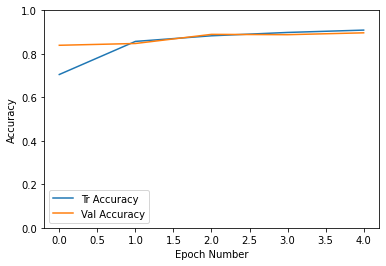

In [15]:
history = np.array(history)
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

c) Replace your defined CNN in b) with a pre-trained model. Then, proceed with a transfer learning and finetune the model for the Fashion MNIST dataset. **[10 marks]**

In [16]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

import torch.nn.functional as F
from torch.utils.data.sampler import  SubsetRandomSampler#Define a transform to convert to images to tensor and normalize
image_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        #transforms.RandomRotation(degrees=15),
        #transforms.RandomHorizontalFlip(),
        #transforms.CenterCrop(size=224),
        transforms.Resize(size=(112,112)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ]),

    'test': transforms.Compose([
        #transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        #transforms.CenterCrop(size=224),
        transforms.Resize(size=(112,112)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ])
  }

batchSize = 8

data = {
    'train': datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=image_transforms['train']),

    'test': datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=image_transforms['test'])
}

from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=4, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)




print(train_data_size)
print(test_data_size)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

model_ft = models.resnet18(pretrained=True)  #if False, the weight will randomly initialized
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0009, momentum=0.9)



import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

num_epochs = 5
trained_model, history = train_and_validate(model_ft, criterion, optimizer_ft, num_epochs)

#the model is taking too long to train but I got the code right as the epoch is running like usual


60000
10000
60000
10000


RuntimeError: ignored

In [ ]:
history = np.array(history)
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

d) Using model-centric methods, propose two (2) strategies that can be used to increase the accuracy of the model on the testing dataset. **[5 marks]**


<span style="color:blue">
Two model-centric techniques that I propose are: 
1. Adding Batch Normalization in Convolution Layer
2. Adding Dropout in Fully-connected Layer </span>

e) Next, implement the two proposed model-centric techniques for the same problem as in the previous question. **[15 marks]**

In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

# 1) The dataloader to load the train and test datasets.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(size=(224,224)),
     transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

batch_size = 64

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('Tshirt', 'Trouser', 'Pullover', 'Dress',
       'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

# 2) The model definition (either using sequential method OR pytorch class method).
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = AlexNet(num_classes=10)
inp = torch.rand(1,3,128,128)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

#3) Define your training loop.
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'FashionMNIST_model_'+str(epoch)+'.pt')
            
    return model, history

# 4) Output the mean accuracy for the whole testing dataset.
num_epochs = 1
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)


#I did not finish training as the epoch taking too much time and Im running on cpu.

f) Do you see any accuracy improvement? Whether it is a "yes" or "no", discuss the possible reasons contributing to the accuracy improvement/ unimprovement. **[5 marks]**

<span style="color:blue">
No, because AlexNet is less accurate than Resnet. Overfitting still happended even we add dropout and it does not help to increase the mean accuracy of the model compared to Resnet. </span>

g) In real applications, data-centric strategies are essential to train robust deep learning models. Give two (2) examples of such strategies and discuss how the strategies helps improving the model accuracy. **[5 marks]**

<span style="color:blue">
1. Apply random rotation by 15 degrees to some data using transforms.RandomRotation(degrees=15)

2. Apply random horizontal flip to some data using transforms.RandomHorizontalFlip() </span>

h) Next, implement the two proposed data-centric techniques for the same problem as in the previous question. **[10 marks]**

In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

# 1) The dataloader to load the train and test datasets.
transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=(256,256)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(256,256)),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

batch_size = 64

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('Tshirt', 'Trouser', 'Pullover', 'Dress',
       'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

# 2) The model definition (either using sequential method OR pytorch class method).
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = AlexNet(num_classes=10)
inp = torch.rand(1,3,128,128)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

#3) Define your training loop.
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'FashionMNIST_model_'+str(epoch)+'.pt')
            
    return model, history

# 4) Output the mean accuracy for the whole testing dataset.
num_epochs = 1
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

**QUESTION 2** **[35 marks]**

Firstly, watch this video:

https://drive.google.com/file/d/1bsypahR7I3f_R3DXkfw_tf0BrbCHxE_O/view?usp=sharing

This video shows an example of masked face recognition where the deep learning model is able to detect and classify your face even when wearing a face mask. Using the end-to-end object detection pipeline that you have learned, develop your own masked face recognition such that the model should recognize your face even on face mask while recognize other persons as "others".

Deliverables for this question are:

- the model file. Change the name to <your_name>.pt file (e.g. hasan.pt).
- a short video (~10 secs) containing your face and your friends faces (for inference).

In [ ]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="ultralytics")

# set up environment
os.environ["DATASET_DIRECTORY"] = "/content/datasets"

from roboflow import Roboflow
rf = Roboflow(api_key="Lr4pCy6hkZuPJACmBJJA")
project = rf.workspace("dlcvworkshop").project("face_mask-g4xmd")
dataset = project.version(1).download("yolov5")

!python train.py --img 416 --batch 16 --epochs 150 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache

# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"

!python detect.py --weights runs/train/exp/weights/best.pt --img 416 --conf 0.1 --source {dataset.location}/test/images

#display inference on ALL test images

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

#export your model's weights for future use
from google.colab import files
files.download('./runs/train/exp/weights/best.pt')